<a href="https://colab.research.google.com/github/adikeshn/EMG-Analysis-Research/blob/main/Hand_gesture_recognition_via_surface_electromyograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Code

In [ ]:
!pip install wfdb
!pip install PyWavelets
!pip install statsmodels
!pip install scikit-image
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.5 MB/s eta 0:00:00
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.13.2-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached Mako-1.3.5-py3-none-any.whl.metadata (2.9 kB)
Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from scipy.io import savemat
import wfdb
import pywt
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.datasets import make_classification



In [ ]:
def get_txt_file():
  with open("files.txt", "w") as f:
    for i in range(1, 44):
      for j in range(1, 2):
        for k in [15, 16]:
          f.write(f"https://physionet.org/files/grabmyo/1.1.0/Session1/session1_participant{i}/session1_participant{i}_gesture{k}_trial{j}.dat" + "\n")
          f.write(f"https://physionet.org/files/grabmyo/1.1.0/Session1/session1_participant{i}/session1_participant{i}_gesture{k}_trial{j}.hea" + "\n")
get_txt_file()

In [ ]:
!wget -i files.txt -P data > /dev/null 2>&1


In [ ]:
def get_data_from_file(file_path):
  # Set the path for the single .dat file
  dat_file_path = file_path

  # Channel mappings for forearm and wrist (assuming the same mappings as in the original script)
  forearm_channels = np.concatenate((np.ones(8), np.ones(8), np.zeros(8), np.zeros(8)))
  wrist_channels = np.concatenate((np.zeros(8), np.zeros(8), np.zeros(1), np.ones(6), np.zeros(2), np.ones(6), np.zeros(1)))

  # Initialize matrices for forearm and wrist data
  data_forearm = np.zeros((10240, 16), dtype=np.float64)  # Adjust the shape as per your requirement
  data_wrist = np.zeros((10240, 12), dtype=np.float64)    # Adjust the shape as per your requirement

  # Load WFDB data
  record = wfdb.rdrecord(dat_file_path[:-4])  # Remove the .dat extension for wfdb.rdrecord

  # Extract signals and other information
  data_emg = record.p_signal

  # Extract forearm and wrist data based on channel mappings
  data_forearm = data_emg[:, forearm_channels.astype(bool)]
  data_wrist = data_emg[:, wrist_channels.astype(bool)]

  return [data_forearm, data_wrist]

In [ ]:
def get_channel(data, participant, channel):
  return data[participant][:, channel]

def plot_channel(data, participant, channel):
  plt.plot(get_channel(data, participant, channel))

In [ ]:
forearm_data = []
wrist_data = []
classification = []
for file in os.listdir("data"):
  if not file.endswith(".dat"):
    continue

  file_path = os.path.join("data", file)
  match = re.search(r"gesture(\d+)", file_path)
  gesture_number = match.group(1)

  if (gesture_number == "15" or gesture_number == "16"):
    data = get_data_from_file(file_path)
    forearm_data.append(data[0])
    wrist_data.append(data[1])
    classification.append(str(gesture_number))

fs = 2048
forearm_data = np.array(forearm_data)
wrist_data = np.array(wrist_data)
classification = np.array(classification)


In [ ]:
def preprocess_signal(channel, lowcut, highcut, fs=fs, window_size=3, order=6):

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')

    channel = signal.lfilter(b, a, channel)
    channel = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))

    f, p = signal.periodogram(channel, fs)

    return channel

lowcut = 20
highcut = 400

channel = get_channel(forearm_data, 2, 1)
y = preprocess_signal(channel, lowcut, highcut)



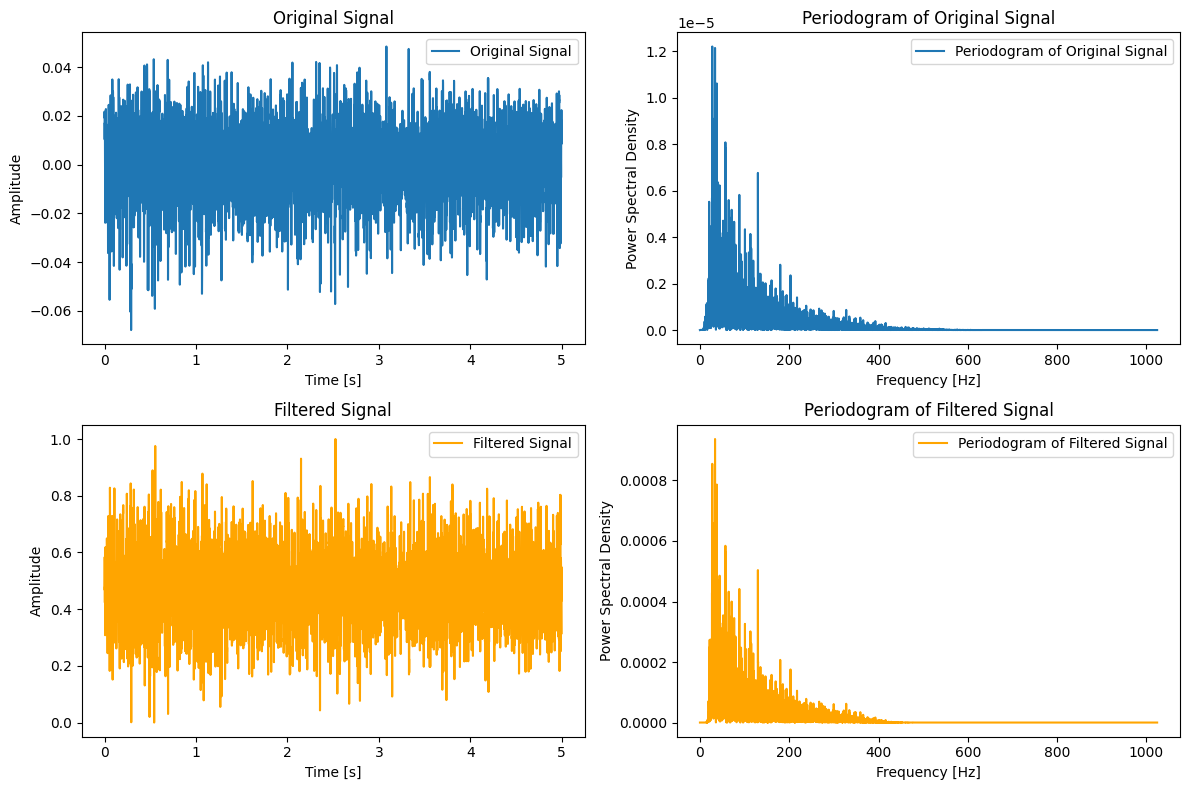

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
t = np.arange(len(channel)) / fs


# Original signal
axs[0, 0].plot(t, channel, label='Original Signal')
axs[0, 0].set_title('Original Signal')
axs[0, 0].set_xlabel('Time [s]')
axs[0, 0].set_ylabel('Amplitude')
axs[0, 0].legend()

f, p = signal.periodogram(channel, fs)

# Periodogram of original signal
axs[0, 1].plot(f, p, label='Periodogram of Original Signal')
axs[0, 1].set_title('Periodogram of Original Signal')
axs[0, 1].set_xlabel('Frequency [Hz]')
axs[0, 1].set_ylabel('Power Spectral Density')
axs[0, 1].legend()

# Filtered signal
axs[1, 0].plot(t, y, label='Filtered Signal', color='orange')
axs[1, 0].set_title('Filtered Signal')
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('Amplitude')
axs[1, 0].legend()

f, p = signal.periodogram(y, fs)

# Periodogram of filtered signal
axs[1, 1].plot(f, p, label='Periodogram of Filtered Signal', color='orange')
axs[1, 1].set_title('Periodogram of Filtered Signal')
axs[1, 1].set_xlabel('Frequency [Hz]')
axs[1, 1].set_ylabel('Power Spectral Density')
axs[1, 1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
def maxima_based(channel, threshold):
  peaks, _ = signal.find_peaks(channel, height=threshold)
  return peaks

def wavelet_based(channel, threshold, min, max):
  peaks = signal.find_peaks_cwt(channel, np.arange(min, max))
  peaks = peaks[channel[peaks] >= threshold]
  return peaks

def savgol_filter_based(channel, threshold, window_length=10, polyorder=2):

  filtered = signal.savgol_filter(channel, window_length, polyorder)
  peaks, _ = signal.find_peaks(filtered, height=threshold)
  return peaks, filtered

def plot_peaks(channel, peaks):
  plt.plot(channel[0:1000])
  plt.show()

def extract_features(channel, fs):

    features = []

    #Time domain features
    features.append(np.mean(channel))  # Mean
    features.append(np.std(channel))   # Standard deviation

    diff_signal = np.diff(channel)
    f, p = signal.periodogram(channel, fs)

    #Frequency domain features
    features.append(np.max(p))   # Maximum power spectral density
    features.append(np.argmax(p))  # Frequency with maximum power
    features.append(np.sum(p * f) / np.sum(p))  # Power-weighted mean frequency

    mean_rms = np.mean(np.sqrt(np.mean(channel**2, axis=0)))

    peaks = wavelet_based(channel, 0, 1, 25)
    peak_amplitudes = channel[peaks]

    # Peak features
    features.append(len(peaks))  # Number of peaks
    features.append(peaks[np.argmax(peak_amplitudes)])  # Time of peak with maximum amplitude
    features.append(np.mean(peak_amplitudes))  # Mean amplitude of peaks
    features.append(np.std(peak_amplitudes))  # Standard deviation of peak amplitudes


    # Time Frequency features
    # Perform DWT with Daubechies wavelet of order 2 (db2) for 4 levels
    wavelet = 'db2'
    coeffs = pywt.wavedec(channel, wavelet, level=4)

    cA4, cD4, cD3, cD2, cD1 = coeffs

    # Mean absolute value features from coefficients
    features.append(np.mean(np.abs(cD4)))

    features = np.array(features)

    return features





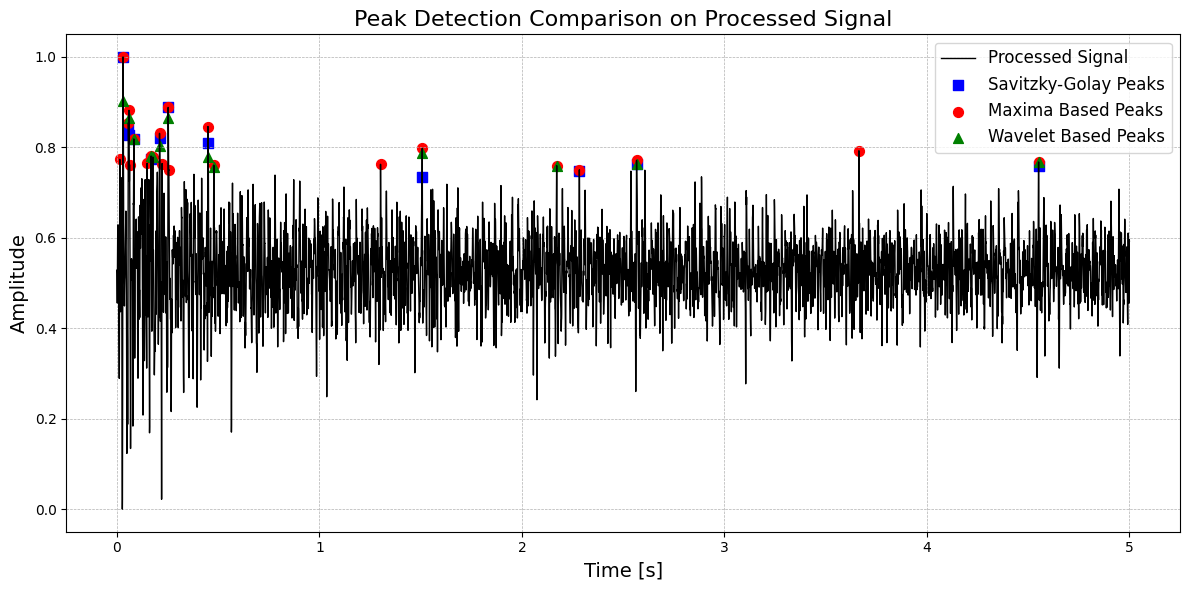

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


l = preprocess_signal(get_channel(forearm_data, 3, 1), lowcut, highcut)

threshold = 0.75
maxima_peaks = maxima_based(l, threshold)
wavelet_peaks = wavelet_based(l, threshold, 1, 25)
savgol_peaks, filt = savgol_filter_based(l, threshold)

time = np.arange(len(l)) / fs
plt.figure(figsize=(12, 6))

plt.plot(time, l, label="Processed Signal", color='black', linewidth=1)

# Scatter plots for different peak detection methods
plt.scatter(time[savgol_peaks], l[savgol_peaks], color="blue", marker='s', s=50, label="Savitzky-Golay Peaks")

plt.scatter(time[maxima_peaks], l[maxima_peaks], color="red", marker='o', s=50, label="Maxima Based Peaks")

plt.scatter(time[wavelet_peaks], l[wavelet_peaks], color="green", marker='^', s=50, label="Wavelet Based Peaks")

# Labels and title
plt.title("Peak Detection Comparison on Processed Signal", fontsize=16)
plt.xlabel("Time [s]", fontsize=14)
plt.ylabel("Amplitude", fontsize=14)

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show plot
plt.show()


In [ ]:
features_full = []
feature_name = []
forearm_channels = 16
wrist_channels = 12

for j in range(forearm_channels + wrist_channels):
  if (j < forearm_channels):
    sub = -1
    name = "forearm"
  else:
    sub = forearm_channels-1
    name = "wrist"
  feature_name = np.concatenate((feature_name, ["ME" + " " + name + " " + str(j-sub), "SD" + " " + name + " " + str(j-sub), "MP" + " " + name + " " + str(j-sub),
                                                "MPF" + " " + name + " " + str(j-sub), "PWMF" + " " + name + " " + str(j-sub), "NP" + " " + name + " " + str(j-sub),
                                                "MPT"+ " " + name + " " + str(j-sub), "MPH" + " " + name + " " + str(j-sub), "SDPH" + " " + name + " " + str(j-sub),
                                                "CD4" + " " + name + " " + str(j-sub) ]))

for i in range(forearm_data.shape[0]):


  features = []

  for j in range(forearm_channels):
    c = preprocess_signal(get_channel(forearm_data, i, j), lowcut, highcut)
    features = np.concatenate((features, extract_features(c, fs)))


  for j in range(wrist_channels):
    c = preprocess_signal(get_channel(wrist_data, i, j), lowcut, highcut)
    features = np.concatenate((features, extract_features(c, fs)))

  features_full.append(features)

features_full = np.array(features_full)
feature_name = np.array(feature_name)

In [ ]:
f = pd.DataFrame(features_full, columns =feature_name)
feature_matrix = f.copy()
feature_matrix["Classification"] = classification


In [ ]:
X = f.to_numpy()
y = classification

In [ ]:
X.shape


(86, 280)

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import numpy as np

kfold = StratifiedKFold(n_splits=5)
precision_list = []
recall_list = []
f1_list = []
accuracy_list = []

model = RandomForestClassifier(random_state=1)

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate precision, recall, f1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Store the results for both classes
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)

# Convert lists to numpy arrays for easier manipulation
precision_array = np.array(precision_list)
recall_array = np.array(recall_list)
f1_array = np.array(f1_list)
accuracy_array = np.array(accuracy_list)

# Calculate mean and standard deviation for each class
mean_precision = np.mean(precision_array, axis=0)
std_precision = np.std(precision_array, axis=0)

mean_recall = np.mean(recall_array, axis=0)
std_recall = np.std(recall_array, axis=0)

mean_f1 = np.mean(f1_array, axis=0)
std_f1 = np.std(f1_array, axis=0)

# Calculate mean and standard deviation for accuracy (single value, not per class)
mean_accuracy = np.mean(accuracy_array)
std_accuracy = np.std(accuracy_array)

# Create a formatted report for each class
for class_index in range(len(mean_precision)):
    print(f"Class {class_index}:")
    print(f"  Precision: {mean_precision[class_index]:.3f} ± {std_precision[class_index]:.3f}")
    print(f"  Recall: {mean_recall[class_index]:.3f} ± {std_recall[class_index]:.3f}")
    print(f"  F1-Score: {mean_f1[class_index]:.3f} ± {std_f1[class_index]:.3f}")
    print()

# Print accuracy (single value, not per class)
print(f"Overall Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(accuracy_array)

Class 0:
  Precision: 0.958 ± 0.052
  Recall: 0.978 ± 0.044
  F1-Score: 0.966 ± 0.028

Class 1:
  Precision: 0.978 ± 0.044
  Recall: 0.953 ± 0.058
  F1-Score: 0.963 ± 0.030

Overall Accuracy: 0.965 ± 0.029
[1.         0.94117647 0.94117647 1.         0.94117647]


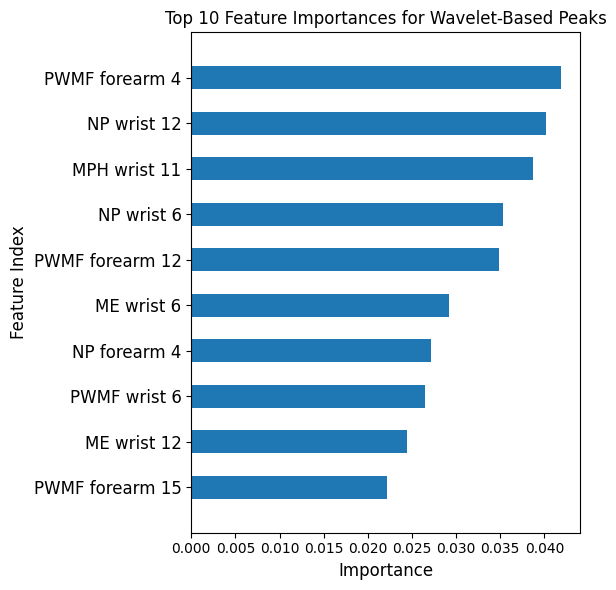

In [ ]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_features = feature_name[top_indices]

# Plotting the top 10 features
plt.figure(figsize=(6, 6))
plt.title("Top 10 Feature Importances for Wavelet-Based Peaks", fontsize=12)  # Increase title font size

# Horizontal bar plot with decreased bar height
plt.barh(range(top_n), top_importances, align="center", height=0.5)
plt.yticks(range(top_n), top_features, fontsize=12)  # Increase y-axis labels font size
plt.ylim([-1, top_n])
plt.xlabel("Importance", fontsize=12)  # Increase x-axis label font size
plt.ylabel("Feature Index", fontsize=12)  # Increase y-axis label font size

# Invert the y-axis to have the most important feature at the top
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:


X, Y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.2, random_state=42)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)  # Number of Trees
    max_depth = trial.suggest_int('max_depth', 5, 30)  # Maximum Depth
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])  # Number of Features
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])  # Bootstrapping

    rfc = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42
    )

    rfc.fit(X_train, Y_train)

    preds = rfc.predict(X_validation)

    accuracy = accuracy_score(Y_validation, preds)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, n_jobs=-1)

best_trial = study.best_trial

print("Best Parameters Found:", best_trial.params)

best_model = RandomForestClassifier(**best_trial.params, random_state=42)
best_model.fit(X_train, Y_train)

preds = best_model.predict(X_validation)

print("Classification Report:\n", classification_report(Y_validation, preds))
print(f"Accuracy: {accuracy_score(Y_validation, preds)}")
